<a href="https://colab.research.google.com/github/zahidhamidi/ML-Project/blob/main/Rule_based_method_dataframe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from tkinter.constants import NONE

nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [48]:
df = pd.read_excel("/content/sample_data/robust_test_dataset.xlsx")
# df_stuck_pipe = df[df["dataset"] == "stuck pipe"]
df_pbu = df[df["dataset"] == "pressure build-up"]
# df_oil_shows = df[df["dataset"] == "oil shows"]
# df_gbearing = df[df["dataset"] == "gas bearing"]
# df_fc = df[df["dataset"] == "fluid communication"]

df = df_pbu

In [49]:
# Define the topics as flexible terms (subwords or whole words)
# topics = ["gas show" , "fluid communication" , "gas bearing" , "h2s" , "co2" , "stuck pipe" , "pressure build up"]
topics = ["pressure build up"]

# Define the negation terms pattern with case-insensitivity
negation_terms = r'(?i)(?:(?<=\s)|^)(no|non|unlikely|none|not|nor|without|lack|rather)(?=\s|$|\b)'

# Initialize a WordNet lemmatizer
# lemmatizer = WordNetLemmatizer()

# Define a custom lemmatization rule to replace "ized" with "e"
def custom_lemmatizer(word):
    if word.endswith("ized"):
        return re.sub(r'ized$', 'e', word)
    elif word.endswith("ing"):
        return re.sub(r'ing$', 'e', word)
    else:
        return word
        # return lemmatizer.lemmatize(word)

# Initialize a list to store selected sentences
selected_sentences = []

# Initialize a flag to check for both topic terms and negation terms
both_detected = False

# Iterate over the 'date' column and apply .lower() only to string values
for index, row in df.iterrows():
    if isinstance(row['doc_text_original'], str):
        # Apply .lower() to string values
        text = row['doc_text_original'].lower()  # Convert to lowercase

    # Tokenize the text into sentences using NLTK's sent_tokenize
    sentences = sent_tokenize(text)

    # Initialize flags to check for both topic terms and negation terms
    topic_found = False
    negation_detected = False

    for sentence in sentences:
      # Tokenize the sentence into words
      words = word_tokenize(sentence)

      # Lemmatize each word using the custom lemmatizer
      lemmatized_words = [custom_lemmatizer(word) for word in words]

      # Join the lemmatized words back into a sentence
      lemmatized_sentence = ' '.join(lemmatized_words)

      # Check if the sentence contains any of the specified topics (partial matches)
      for topic_pattern in topics:
        words = topic_pattern.split()

      if len(words) >= 2:
        # Initialize an empty pattern string
        pattern_string = r'(?i)(?:(?<=\s)|^)'

        # Loop through the words and add them to the pattern
        for i in range(len(words)):
            pattern_string += re.escape(words[i])

            # Add optional characters (like hyphens) between words (except for the last word)
            if i < len(words) - 1:
                pattern_string += r'\s*-*\s*'

        # Add the closing part of the pattern
        pattern_string += r'(?=\s|$)'

        # Compile the regex pattern
        topic_pattern = re.compile(pattern_string)

        if re.search(topic_pattern, lemmatized_sentence.lower()):
            topic_found = True
            break

        """
        if len(words) >= 2:
          # Define the regex pattern for two-word topics with optional characters in the middle
          two_word_topic_pattern = re.compile(rf'(?i)(?:(?<=\s)|^)({re.escape(words[0])}\s*-*\s*{re.escape(words[1])})(?=\s|$)')
          if re.search(two_word_topic_pattern, lemmatized_sentence.lower()):
            topic_found = True
            break
        """

      else:
          single_pattern = rf'(?i)(?:(?<=\s)|^)({re.escape(words[0])})(?=\s|$)'
          if re.search(single_pattern, lemmatized_sentence.lower()):
              topic_found = True
              break

      # Check if the lemmatized sentence contains negation terms
      if re.search(negation_terms, lemmatized_sentence.lower()):
          negation_detected = True
      else:
          negation_detected = False

      # If a topic term is found and either no negation terms are found or negation_detected is False, append the sentence
      if (topic_found is True) and (negation_detected is True):
          selected_sentences.append(lemmatized_sentence)
          both_detected = True
          break

      elif (topic_found is True) and (negation_detected is False):
          selected_sentences.append(lemmatized_sentence)
          both_detected = True
          break


    # If no sentence with both topic and negation terms is found, append the first sentence without a negation term
    if not both_detected or topic_found is False:
        selected_sentences.append(lemmatized_sentence)



 # Add the selected_sentences as a new column named 'selected_sentence'
df['selected_sentence'] = selected_sentences

print(len(selected_sentences))


500


In [50]:
# Determine the prediction (0 or 1) based on the presence of negation terms in selected_sentence
for index, row in df.iterrows():
    selected_sentence = row['selected_sentence']

    if selected_sentence is not None:
        # Check if the lemmatized sentence contains negation terms
        if re.search(negation_terms, selected_sentence.lower()):
            prediction = 0  # Negation terms found, set the prediction to 0
        else:
            prediction = 1  # No negation terms found, set the prediction to 1
    else:
        prediction = 0  # Handle the case where selected_sentence is None

    df.at[index, 'predicted'] = prediction

# Print the DataFrame with the 'label' column
df[['doc_text_original', 'selected_sentence', 'label_code', 'predicted']]

,doc_text_original,selected_sentence,label_code,predicted
101,'Learning Points: eo Successful operation. Ris...,co stones â¥ sand 1e gre c pipe in t irs ( stu...,0,0.0
102,"'Rigged and ran 13 3/8"" casing. 2.50 Run 13.3/...","3.50 tue 26-dec 16:30 stuck pipe at 760m , no ...",1,0.0
103,'8 2â€ BHA The BHA design for this section wa...,' 8 2â€ bha the bha design for this section w...,1,1.0
104,'= BHA design â€” Small BHAs are clearly an ad...,'= bha design â€ ” small bhas are clearly an a...,1,1.0
105,"'+ 8"" 1/2 PHASE (4210 - 4942 m and 4262 to 465...",increase mud weight to 1.79 . ',1,1.0
...,...,...,...,...
596,"'The 36"" hole was drilled from seabed at 138 t...",the 26 '' hole was drilled from 174 to 360m wi...,1,1.0
597,'o Drilled Grebe Sands very quickly and with n...,maintained 175 mesh shaker screens on axiom sh...,0,1.0
598,'Tight hole and drag during trips was also evi...,dure the 8 % section packe off and stuck pipe ...,1,1.0
599,'Tight hole and drag during trips was also evi...,dure the 8 % section packe off and stuck pipe ...,1,1.0


In [51]:
# Assuming 'df' is your DataFrame
df.to_excel("dataset_sp.xlsx", index=False)

## **Prediction Evaluation**

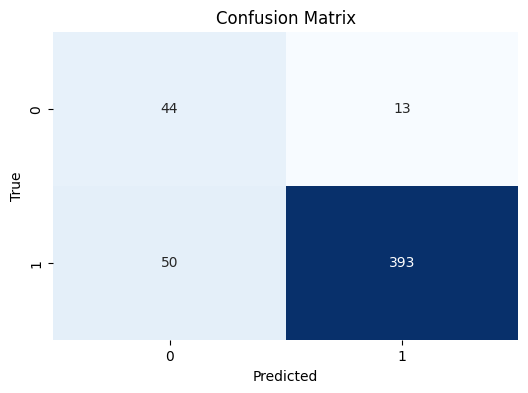

Accuracy: 0.87
Precision: 0.72
Recall: 0.83
F1 Score: 0.75


In [52]:
# Assuming you have loaded your DataFrame 'df' with the columns 'label_code' and 'predicted_label_code'
y_true = df['label_code']
y_pred = df['predicted']

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate additional evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


## **Evaluating by dataset group**